In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from visualization.utils import count_of_appointment, age_related_diseases 
from data_preprocessing.utils import preprocess_categorical_to_binary, change_age_range
%matplotlib inline

In [4]:
df = pd.read_csv('../data/raw/KaggleV2-May-2016.csv') 

In [6]:
print(f'Dataset has {df.shape[0]} rows and {df.shape[1]} columns')

print(f'We see that one person has more then one appoitment, bacause we have {df.shape[0]} appointments and only {len(df.PatientId.unique())} persons')

len(df.AppointmentID.unique())
print('Appitment ID is unique. For every appoitnment we have new number. We can use this number in index')

Dataset has 110527 rows and 16 columns
We see that one person has more then one appoitment, bacause we have 110527 appointments and only 62299 persons
Appitment ID is unique. For every appoitnment we have new number. We can use this number in index


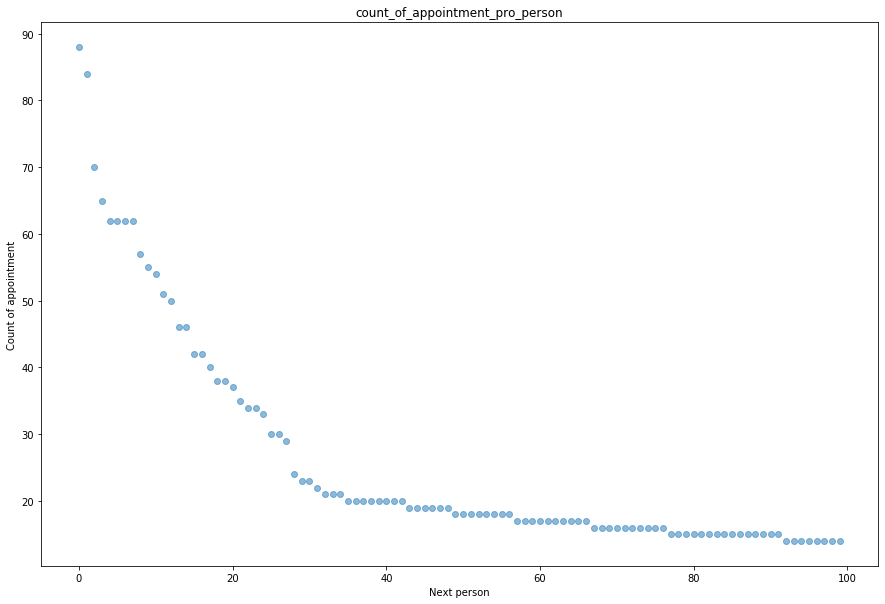

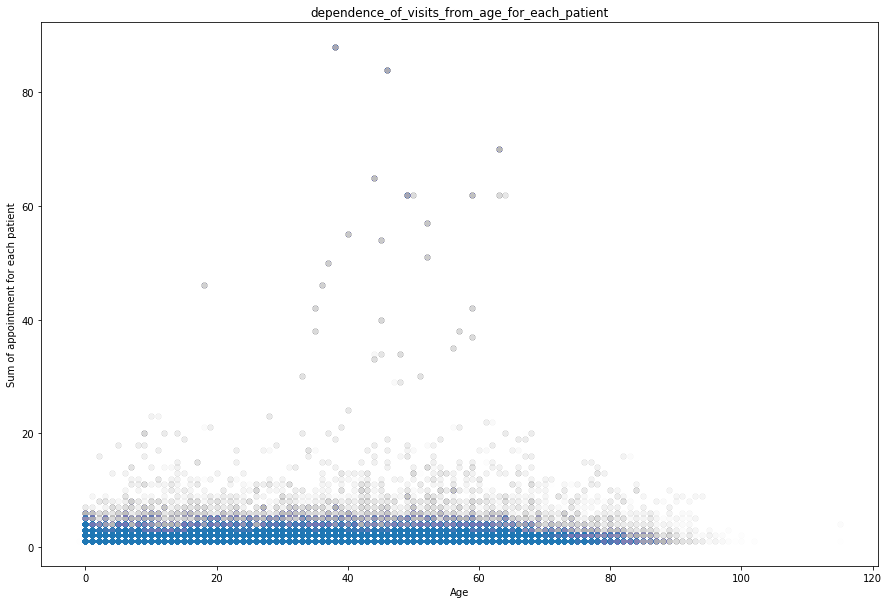

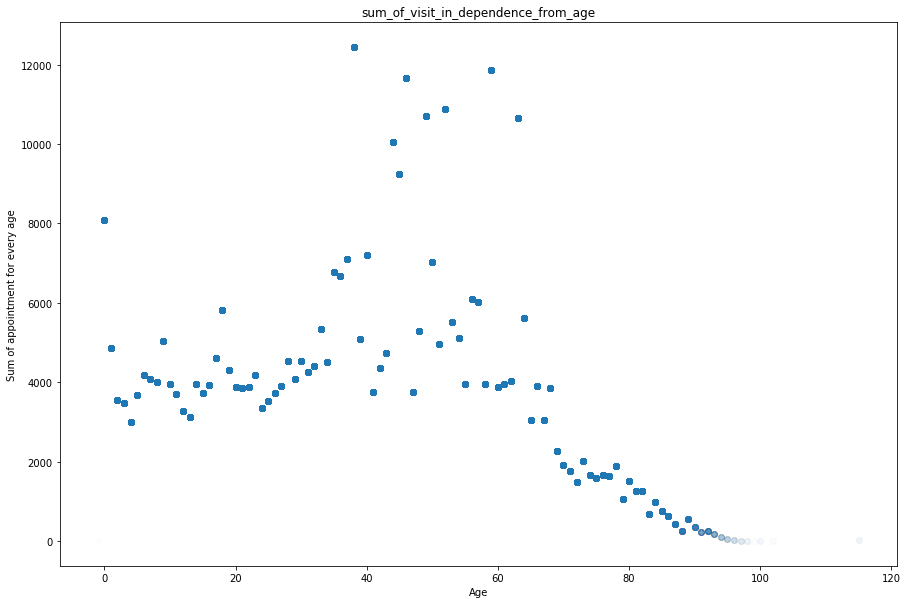

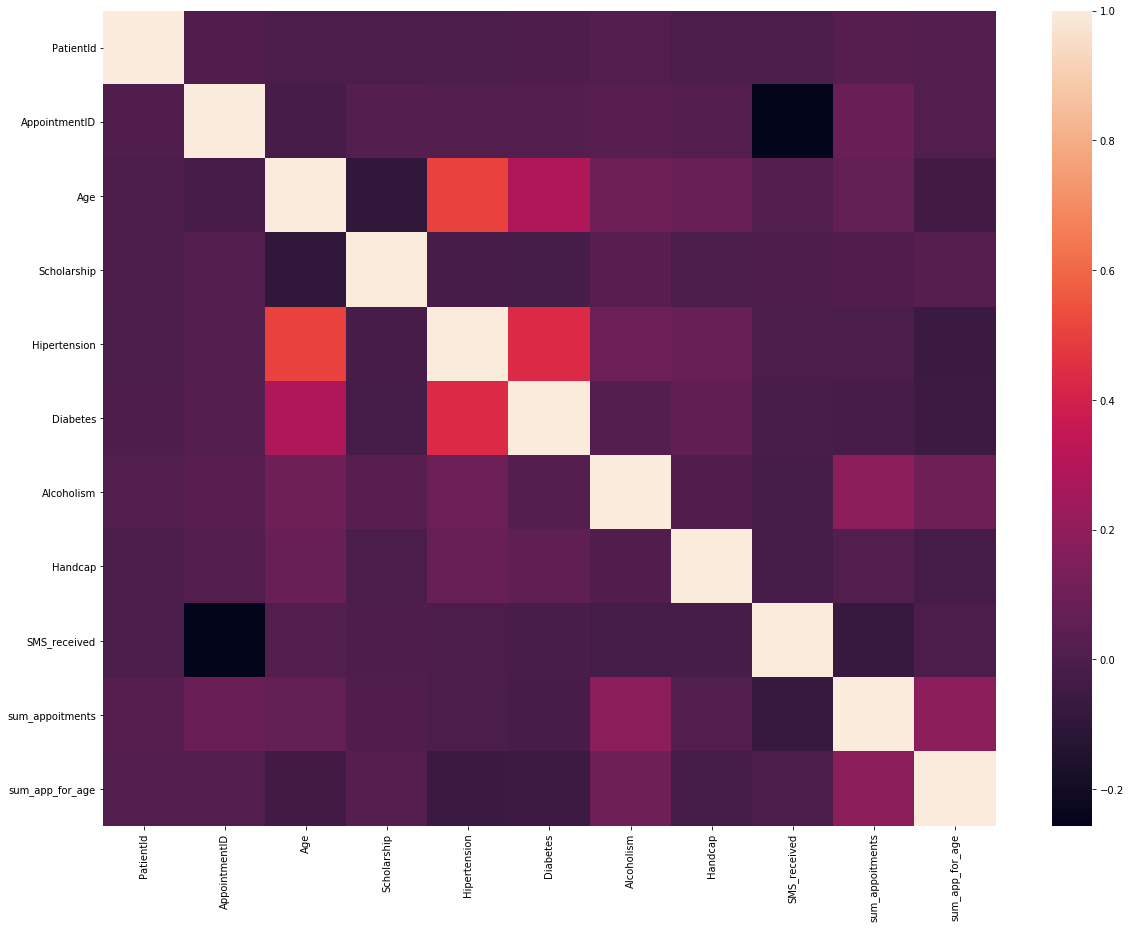

In [5]:
#### ### sum appoitments 
appoitment_pro_person = df.PatientId.value_counts().reset_index().head(100)
appoitment_pro_person['ind'] = appoitment_pro_person.index
df['sum_appoitments'] = df.groupby('PatientId')['AppointmentID'].transform('count')
df['sum_app_for_age'] = df.groupby('Age')['sum_appoitments'].transform('sum')


count_of_appointment(plot_name = 'count_of_appointment_pro_person',x = appoitment_pro_person['ind'],y = appoitment_pro_person['PatientId'],xlabel = 'Next person',ylabel = 'Count of appointment',alpha=0.5)
count_of_appointment(plot_name = 'dependence_of_visits_from_age_for_each_patient',x = df['Age'],y = df['sum_appoitments'],xlabel = 'Age',ylabel = 'Sum of appointment for each patient',alpha=0.005)
count_of_appointment(plot_name = 'sum_of_visit_in_dependence_from_age',x = df['Age'],y = df['sum_app_for_age'],xlabel = 'Age',ylabel = 'Sum of appointment for every age',alpha=0.01)

"""
Age column
- min is -1 what means that here we have some mistake
- max value is 115. We can drop all values which are more then 100"""

### Correlation for numeric values
plt.figure(figsize=(20,15))
sns.heatmap(df.corr())






In [44]:
df = preprocess_categorical_to_binary(df)
df = change_age_range(df)
df_prep_corr = df.corr().abs()
pd.options.display.max_rows = 100
s = df_prep_corr.unstack()
s = s.sort_values(kind="quicksort",ascending=False)
s = pd.DataFrame(s[s<1])[:20]
s.to_csv('../reports/tables/correlation_with_data_change_to_numeric.csv')


/home/kasia/Python Projects/Medical-Appoitnment-No-Show/src/data_preprocessing/utils.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col][X[col]<0]=0
/home/kasia/Python Projects/Medical-Appoitnment-No-Show/src/data_preprocessing/utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col][X[col]>95]=95


No-show  Gender
0        0         57246
         1         30962
1        0         14594
         1          7725
Name: Gender, dtype: int64
0    0.796854
1    0.800321
Name: Gender, dtype: float64


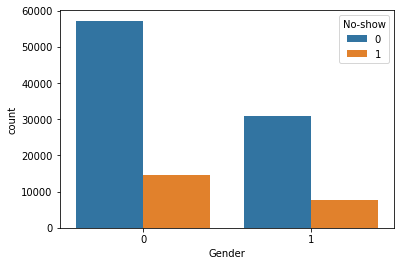

In [26]:
sns.countplot(x="Gender", hue="No-show", data=df)
plt.savefig('../reports/figures/show_no_show_in_dependence_from_gender.png')
#Show, No-Show
print(df.groupby('No-show')['Gender'].value_counts())
# Percentage of woman/man who don't go to doctor
print(df.Gender[df['No-show']==0].value_counts()/df.Gender.value_counts())

In [38]:
print("{} of woman in age 60 have diabetes".format(len(df[(df['Gender']=='F')&(df['Age']==60)&(df['Diabetes']==1)])/len(df[(df['Gender']=='F')&(df['Age']==20)])))
print("{} of woman in age 20 have diabetes".format(len(df[(df['Gender']=='F')&(df['Age']==20)&(df['Diabetes']==1)])/len(df[(df['Gender']=='F')&(df['Age']==20)])))

print("Strong correlation between Age and Hipertension. Hipertension is also correlated with Diabetes and Alcoholismus")
df[['Age','Diabetes','Alcoholism','Hipertension']].corr()

0.16071428571428573 of woman in age 60 have diabetes
0.002819548872180451 of woman in age 20 have diabetes
Strong correlation between Age and Hipertension. Hipertension is also correlated with Diabetes and Alcoholismus


,Age,Diabetes,Alcoholism,Hipertension
Age,1.000000,0.292391,0.095811,0.504586
Diabetes,0.292391,1.000000,0.018474,0.433086
Alcoholism,0.095811,0.018474,1.000000,0.087971
Hipertension,0.504586,0.433086,0.087971,1.000000


In [65]:
percentage_show = (df.Gender[df['No-show']==0].value_counts()/(df.Gender.value_counts())*100)
print("{} percent of woman and {} percent of man appear".format(percentage_show[0],percentage_show[1]))
percentage_no_show = df.Gender[df['No-show']==1].value_counts()/df.Gender.value_counts()
print("{} percent of woman and {} percent of man don't appear".format(percentage_no_show[0],percentage_no_show[1]))



79.68541202672606 percent of woman and 80.03205211052808 percent of man appear
0.20314587973273943 percent of woman and 0.19967947889471915 percent of man don't appear


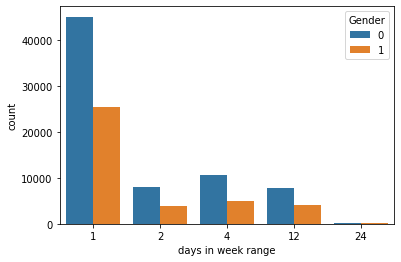

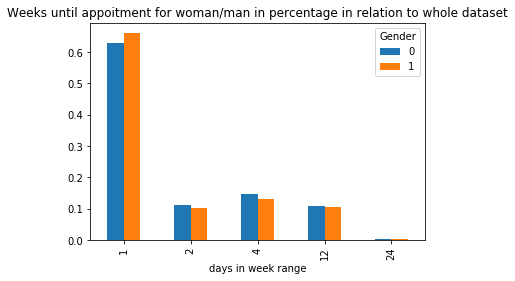

In [106]:
cut_bins = [-0.001, 7, 14, 28, 84,168]
df['days in week range']=pd.cut(df['DaysBetween'],bins=cut_bins, labels = [1,2,4,12,24])
#without normalisation
sns.countplot(x='days in week range',hue='Gender',data=df)

#with normalisation
aft_cut = df.groupby(df['days in week range'])['Gender'].value_counts()
aft_cut
aft_cut = aft_cut.groupby(level=1).apply(lambda x:x / float(x.sum()))
aft_cut 

aft_cut.unstack().plot(kind='bar')
plt.title("Weeks until appoitment for woman/man in percentage in relation to whole dataset")
plt.savefig('../reports/figures/weeks_until_appoitment.png')

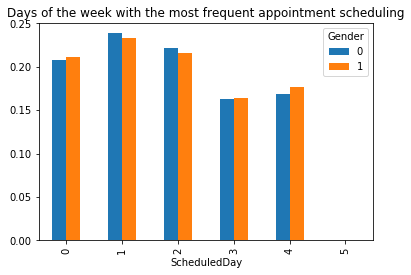

In [86]:
xy = df.groupby(df['ScheduledDay'].apply(lambda x :x.weekday))['Gender'].value_counts()
xy
state_pcts = xy.groupby(level=1).apply(lambda x:x / float(x.sum()))
state_pcts
state_pcts.unstack().plot(kind='bar')
plt.title("Days of the week with the most frequent appointment scheduling")
plt.savefig('../reports/figures/days_of_weeks_with_most_appoitment.png')

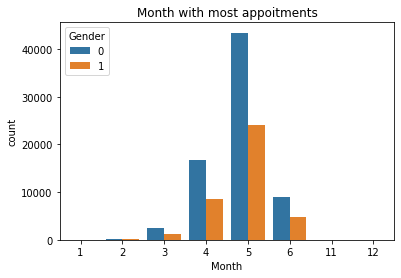

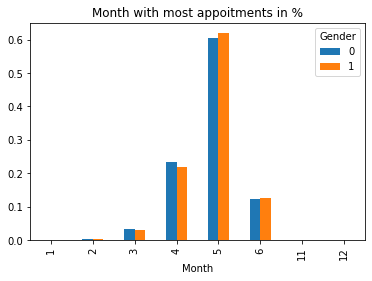

In [105]:
#without normalisation
sns.countplot(x=df['ScheduledDay'].apply(lambda x :x.month),hue='Gender',data=df)
plt.xlabel("Month")
plt.title("Month with most appoitments")
plt.savefig('../reports/figures/month_with_most_appoitment.png')

#with normalisation
zz = df.groupby(df['ScheduledDay'].apply(lambda x:x.month))['Gender'].value_counts()

zz.groupby(level=1).apply(lambda x: x/float(x.sum())).unstack().plot(kind='bar')
plt.xlabel("Month")
plt.title("Month with most appoitments in %")
plt.savefig('../reports/figures/month_with_most_appoitment_in_percent.png')

Text(0.5, 1.0, 'Age vs appoitments')

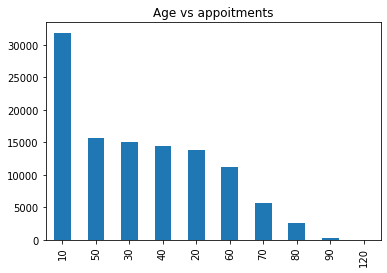

In [94]:
cut_bins = [-2, 20, 30, 40, 50,60,70,80,90,100,120]
df['age_after_cut']= pd.cut(df['Age'],bins=cut_bins, labels = [10, 20, 30, 40, 50,60,70,80,90,120])
df['age_after_cut'].value_counts().plot(kind='bar')
plt.title('Age vs appoitments')


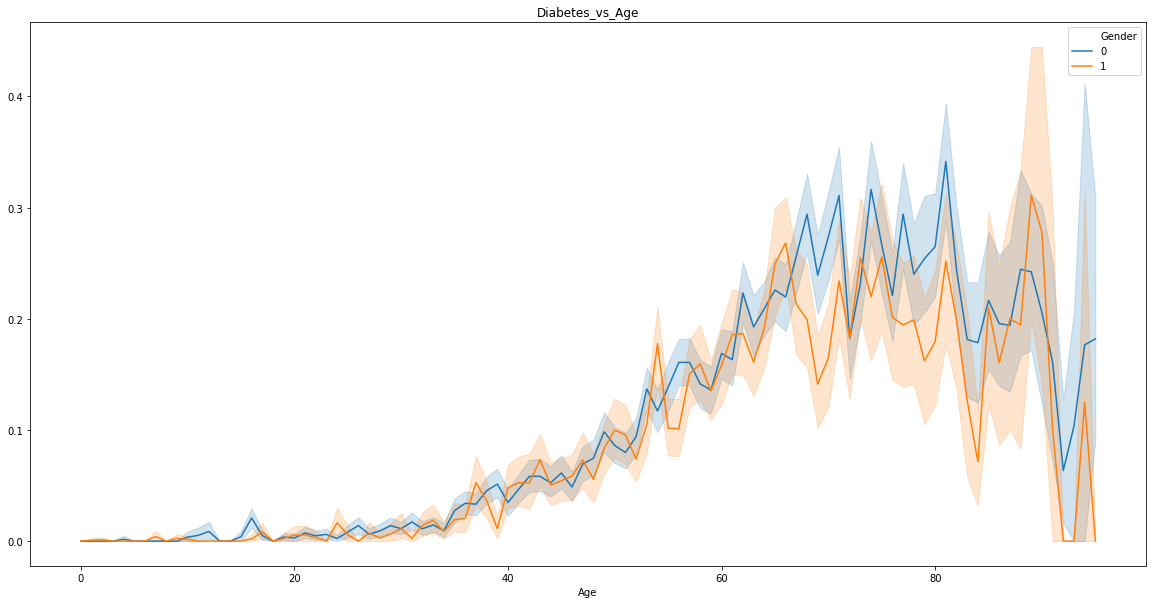

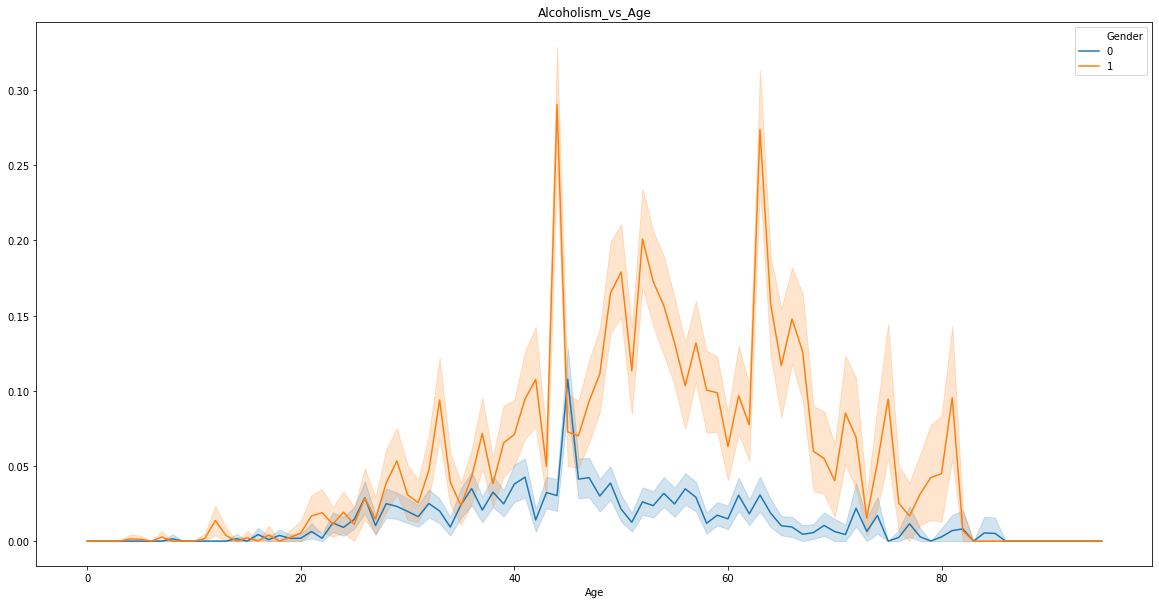

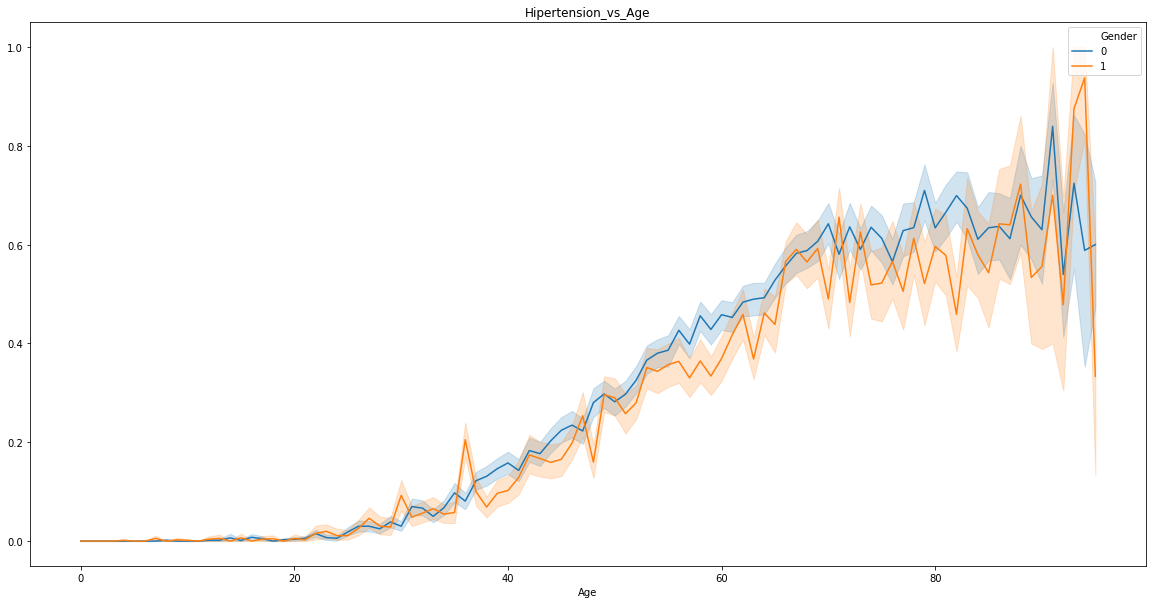

In [112]:
age_related_diseases(df=df, x='Age', y ='Diabetes',xlabel="Age",ylabel='',plot_name = "Diabetes_vs_Age")
age_related_diseases(df=df, x='Age', y ='Alcoholism',xlabel="Age",ylabel='',plot_name = "Alcoholism_vs_Age")
age_related_diseases(df=df, x='Age', y ='Hipertension',xlabel="Age",ylabel='',plot_name = "Hipertension_vs_Age")

In [104]:
#without normalization
df.groupby(df['age_after_cut'])['Gender'].value_counts()

#ag.unstack().plot(kind='bar')
#with normalization
#ag.groupby(level=1).apply(lambda x: x/float(x.sum())).unstack().plot(kind='bar')

ValueError: operands could not be broadcast together with shape (10,) (9,)